In [1]:
import keras
import os 
import sys
import time 
import warnings
import numpy as np
import keras_resnet.models
import seaborn as sns
import scipy.io as sio
import h5py
import matplotlib.pyplot as plt

from keras.optimizers import SGD
from keras.models import Sequential
from keras.layers import Dense, TimeDistributed
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import GRU, LSTM
from keras import backend as K
from keras.applications import imagenet_utils
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img


from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from keras import applications
from keras.optimizers import Adam
from keras.datasets import mnist


%matplotlib inline
warnings.simplefilter("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

Using TensorFlow backend.


Instructions for updating:
Use the retry module or similar alternatives.


In [ ]:
os.listdir()

In [2]:
image_dir = os.sep+'images'+os.sep
labels = os.sep+'labels'+os.sep+'category_GT.mat'

In [3]:
mat_contents = sio.loadmat(os.getcwd() + labels)['GT']
train_labels=np.array(mat_contents)
train_labels.shape

(1856, 1)

In [4]:
file_list = [f for f in os.listdir(os.getcwd() + image_dir) if os.path.isfile(os.path.join(os.getcwd() + image_dir, f))]
file_list.sort()
len(file_list)

1856

In [5]:
inputShape = (150, 150)
img_list =[]

for file in file_list:
    temp = os.getcwd() + image_dir + "/" + file
    #print filename
    
    #print("[INFO] loading and pre-processing image...")
    image = load_img(temp, target_size=inputShape)
    #print (image.size)
    image = img_to_array(image)

    pos = int(file.split(".")[0])
    
    
    #inserting the image at correct index that matches its label
    img_list.insert(pos -1 , image)


train_data = np.array(img_list)  

print("Training Data shape:{}".format(train_data.shape))

Training Data shape:(1856, 150, 150, 3)


In [6]:
def dropData(inputs,labels):
    # some images do not have labels because 
    # it was not possible for an agreed label
    # for some images. We drop them.
    
    ret_data = inputs[np.isfinite(np.ravel(labels))]
    ret_labels = labels[np.isfinite(labels)]
    return(ret_data,ret_labels)

train_data,train_labels = dropData(train_data,train_labels)

In [7]:
train_data.shape

(1104, 150, 150, 3)

In [8]:
train_labels.shape

(1104,)

In [9]:
# normalizing pixel values
train_data /= 255

In [10]:
# shuffle and split into train, validation data
# let sklearn do the dirty work for us.

from sklearn.model_selection import train_test_split as splitter

x_train,x_test,y_train,y_test = splitter(train_data,train_labels,
                                        test_size = 0.33,
                                        random_state = 14,#to get reproducible splits
                                        shuffle = True)
print('Trainin Data:{}\
Validation Data:{}'.format(x_train.shape,x_test.shape))

Trainin Data:(739, 150, 150, 3)Validation Data:(365, 150, 150, 3)


In [13]:
def plot_first_n_images(img_list=img_list,n=9):
    # load data  
    # create a grid of 3x3 images
    plt.figure(figsize = (8,8))
    for i in range(0, n):
        plt.subplot(330 + 1 + i)
        plt.imshow(img_list[i])
    # show the plot
    plt.show()

consolidated dataset


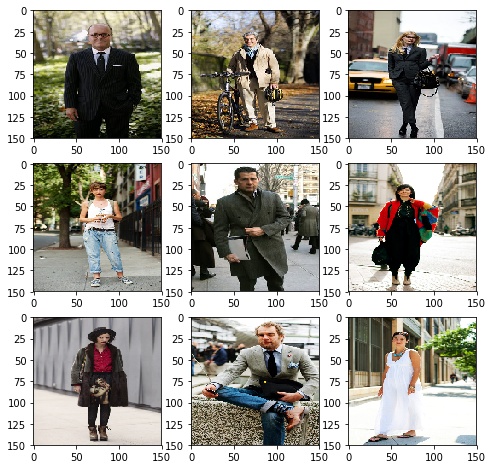

evaluation dataset


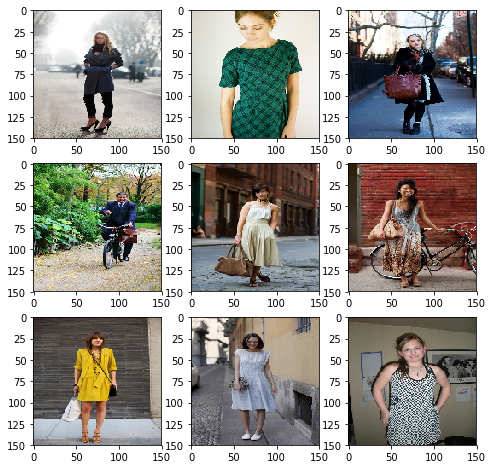

training dataset


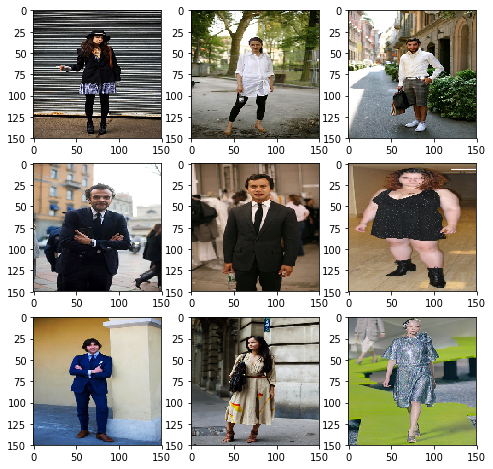

In [14]:
print("consolidated dataset")
plot_first_n_images(train_data)
print("evaluation dataset")
plot_first_n_images(x_test)
print("training dataset")
plot_first_n_images(x_train)

In [15]:
len(set(labels))

17

In [ ]:
def save_bottleneck_features(train_data_filter, 
                             train_labels_filter, 
                             filename = 'bottleneck_features_train.npy',
                             model = 'ResNet50'):
    train_data_aug=[]
    train_labels_aug=[]
    batch_size = 16
    datagen = ImageDataGenerator(featurewise_center=True,
                                 featurewise_std_normalization=True,
                                 horizontal_flip=True,
                                 fill_mode='nearest')
    if model != 'ResNet50':
        model = applications.VGG16(include_top=False,#we will use our predictor
                                   weights='imagenet')#using pretrained weights
    elif model == 'ResNet50':
        model = keras.applications.resnet50.ResNet50(include_top=False, 
                                                     weights='imagenet', 
                                                     input_tensor=None, 
                                                     input_shape=None, 
                                                     pooling=None, 
                                                     classes=1000)

    print("loading gen on training data")
    
    datagen.fit(train_data_filter)
    
    print("generating augmentations of data")
    bottleneck_features_train =[]
    
    i = 0
    print("Total iterations = {}".format((len(train_data_filter) * 10)//batch_size))
  
    for X_batch, y_batch in datagen.flow(train_data_filter, 
                                         train_labels_filter, 
                                         batch_size=batch_size, 
                                         shuffle=False):
        
        train_data_aug.extend(X_batch)
        train_labels_aug.extend(y_batch)
        
        print("in iter ", i)
        
        print("generating bottleneck features")
        bottleneck_features_train_batch = model.predict(
        X_batch,  verbose = 1)
        
        print('\nBottleneck feature shape:{}'.format(bottleneck_features_train_batch.shape))
        print(len(train_data_aug))
        
        bottleneck_features_train.extend(bottleneck_features_train_batch)
        i += 1
        
        if i > (len(train_data_filter) * 10)//batch_size:
            break
            
    bottleneck_features_train = np.array(bottleneck_features_train)
    train_data_aug = np.array(train_data_aug)
    train_labels_aug = np.array(train_labels_aug)
    print('\n_________________\nData Shapes\n_________________\n')
    print('\nBottleneck features:{}'.format(bottleneck_features_train.shape))
    print('\nAugmented Data:{}'.format(train_data_aug.shape))
    print('\nTrain labels:{}'.format(train_labels_aug.shape ))
    print("\nsaving bottleneck features to a file\n")
    #np.save(open(filename, 'w'),
    #    bottleneck_features_train)
    
    return train_data_aug, train_labels_aug, bottleneck_features_train

    

train_data_aug, train_labels_aug, bottleneck_features_train = save_bottleneck_features(x_train, 
                                                                                       y_train, 
                                                                                       'bottleneck_features_ResNet50.npy')

    

eval_data_aug, eval_labels_aug, bottleneck_features_eval = save_bottleneck_features(x_test,
                                                                                    y_test,
                                                                                    'bottleneck_features_eval_ResNet50.npy')


loading gen on training data
generating augmentations of data
Total iterations = 461
in iter  0
generating bottleneck features
